DESCRIPTION

Project Objective: 
Design an algorithm which will tell the fare to be charged for a passenger.

Problem Statement Scenario: 
A fare calculator helps a customer in identifying the fare valid for the trip. They are often used by passengers who are new to a city or tourists to get an estimate of travel costs.
You are provided with a dataset with features like fare amount, pickup and drop location, passenger count, and so on.
Following actions should be performed:
    
    1. Understand the type of data.
    2. Identify the output variable.
    3. Identify the factors which affect the output variable.
    4. Check if there are any biases in your dataset.
    5. Count the null values existing in columns.
    6. Remove the null value rows in the target variable.
    7. Perform train test split.
    8. Predict the accuracy using regression models.
    9. Check and compare the accuracy of the different models.

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import geopy.distance
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import model_selection
from sklearn.preprocessing import PolynomialFeatures
from math import sqrt
from sklearn.preprocessing import StandardScaler
import random
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import datetime
from multiprocessing import pool
from geopy.geocoders import Nominatim
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from geopy.geocoders import Nominatim
import numpy as np
from sklearn.model_selection import cross_val_score

TRAIN_PATH = r'C:\Users\adity\Documents\Machine-Learning--Projects-master\Projects\Course End Projects\Project 9.1 - Uber Fare Prediction\train.csv'
TEST_PATH = r'C:\Users\adity\Documents\Machine-Learning--Projects-master\Projects\Course End Projects\Project 9.1 - Uber Fare Prediction\test.csv'

In [2]:
# Set columns to most suitable type to optimize for memory usage
traintypes = {'fare_amount': 'float32',
              'pickup_datetime': 'str', 
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'uint8'}

cols = list(traintypes.keys())

In [3]:
chunksize = 10000

In [4]:
n = sum(1 for line in open(TRAIN_PATH)) - 1 #number of records in file (excludes header)
s = 100000 #desired sample size
skip = sorted(random.sample(range(1,n+1),n-s)) #the 0-indexed header will not be included in the skip list
df_list = [] # list to hold the batch dataframe
i = 0
distance = pd.Series(dtype="float32")
for df_chunk in tqdm(pd.read_csv(TRAIN_PATH, usecols=cols, dtype=traintypes, chunksize=chunksize, skiprows=skip)):
    
    df_chunk['pickup_datetime'] = df_chunk['pickup_datetime'].str.slice(0, 16)
    df_chunk['pickup_datetime'] = pd.to_datetime(df_chunk['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')
    
    #drop rows with na values
    #drop rows having fare < 0
    #drop rows having abs(latitude) > 90 and abs(longitude) > 180
    df_chunk.dropna(axis=0,how='any',inplace=True)
    df_chunk = df_chunk[~ (df_chunk.fare_amount < 0)]
    df_chunk = df_chunk[~((abs(df_chunk['pickup_latitude']) > 90) | (abs(df_chunk['dropoff_latitude']) > 90) | 
                         (abs(df_chunk['pickup_longitude']) > 180) | (abs(df_chunk['dropoff_longitude']) > 180))]
    
    #create column Distance, based on coordinates
    for lat1,long1,lat2,long2 in zip(df_chunk['pickup_latitude'],df_chunk['pickup_longitude'],df_chunk['dropoff_latitude'],df_chunk['dropoff_longitude']):
        coord_1 = (lat1,long1)
        coord_2 = (lat2,long2)
        dist    = geopy.distance.distance(coord_1,coord_2).km
        df_chunk.loc[((df_chunk['pickup_latitude'] == lat1) & (df_chunk['pickup_longitude'] == long1) &
                      (df_chunk['dropoff_latitude'] == lat2) & (df_chunk['dropoff_longitude'] == long2)),"Distance"] = dist
        
    df_chunk['is_weekday'] = 0
    for idx in df_chunk.index:
        if df_chunk.pickup_datetime.loc[idx].weekday() < 5 :
            df_chunk.loc[idx,'is_weekday'] = 1
    
    # append the chunk to list and merge all
    df_list.append(df_chunk)
    i+=1

10it [05:57, 35.76s/it]


In [5]:
train_df = pd.concat(df_list)

# Delete the dataframe list to release memory
del df_list

# See what we have loaded
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99993 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   fare_amount        99993 non-null  float32            
 1   pickup_datetime    99993 non-null  datetime64[ns, UTC]
 2   pickup_longitude   99993 non-null  float32            
 3   pickup_latitude    99993 non-null  float32            
 4   dropoff_longitude  99993 non-null  float32            
 5   dropoff_latitude   99993 non-null  float32            
 6   passenger_count    99993 non-null  uint8              
 7   Distance           99993 non-null  float64            
 8   is_weekday         99993 non-null  int64              
dtypes: datetime64[ns, UTC](1), float32(5), float64(1), int64(1), uint8(1)
memory usage: 5.1 MB


In [6]:
train_df.head(5)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Distance,is_weekday
0,7.3,2010-05-03 20:30:00+00:00,-73.976540,40.755760,-73.959457,40.763329,1,1.669421,1
1,8.5,2014-03-26 01:43:00+00:00,-73.973747,40.753689,-73.950821,40.782818,1,3.769673,1
2,8.1,2011-02-02 10:48:00+00:00,-73.980515,40.730530,-74.003616,40.722664,1,2.138240,1
3,6.5,2010-04-11 12:21:00+00:00,-73.987343,40.750443,-73.967255,40.761093,2,2.067965,0
4,9.7,2011-05-01 03:17:00+00:00,-73.977600,40.784275,-73.943748,40.793705,4,3.043036,0


In [7]:
train_df.dtypes

fare_amount                      float32
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float32
pickup_latitude                  float32
dropoff_longitude                float32
dropoff_latitude                 float32
passenger_count                    uint8
Distance                         float64
is_weekday                         int64
dtype: object

In [8]:
display(train_df.head(5))
display(train_df.tail(5))

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Distance,is_weekday
0,7.3,2010-05-03 20:30:00+00:00,-73.976540,40.755760,-73.959457,40.763329,1,1.669421,1
1,8.5,2014-03-26 01:43:00+00:00,-73.973747,40.753689,-73.950821,40.782818,1,3.769673,1
2,8.1,2011-02-02 10:48:00+00:00,-73.980515,40.730530,-74.003616,40.722664,1,2.138240,1
3,6.5,2010-04-11 12:21:00+00:00,-73.987343,40.750443,-73.967255,40.761093,2,2.067965,0
4,9.7,2011-05-01 03:17:00+00:00,-73.977600,40.784275,-73.943748,40.793705,4,3.043036,0


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Distance,is_weekday
99995,4.5,2010-12-04 04:49:00+00:00,-73.863907,40.757801,-73.855072,40.751900,3,0.993019,0
99996,20.0,2015-06-11 13:45:00+00:00,-73.966965,40.753281,-73.923897,40.766537,5,3.923289,1
99997,8.0,2013-07-28 18:18:00+00:00,-73.998848,40.754730,-73.983086,40.775040,1,2.618744,0
99998,8.0,2013-02-21 09:55:00+00:00,-74.006371,40.733231,-73.990227,40.739323,5,1.522251,1
99999,8.1,2009-02-09 11:45:00+00:00,-74.009377,40.713066,-73.994949,40.728008,1,2.058914,1


In [9]:
train_df.shape

(99993, 9)

In [10]:
train_df.isnull().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
Distance             0
is_weekday           0
dtype: int64

In [11]:
train_df.is_weekday = train_df.is_weekday.astype('category')
train_df.Distance = train_df.Distance.astype('float32')

In [12]:
train_df.dtypes

fare_amount                      float32
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float32
pickup_latitude                  float32
dropoff_longitude                float32
dropoff_latitude                 float32
passenger_count                    uint8
Distance                         float32
is_weekday                      category
dtype: object

In [13]:
X = train_df.drop(["fare_amount","pickup_datetime"],axis=1)
y = train_df.fare_amount
X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size = 0.3,random_state=42)

In [14]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((69995, 7), (29998, 7), (69995,), (29998,))

In [15]:
lm = LinearRegression()

In [16]:
lm.fit(X_train,y_train)
print(lm.coef_)
print(lm.intercept_)
predict = lm.predict(X_test)
print(sqrt(mean_squared_error(y_test,predict)))
print(lm.score(X_test,y_test))

[-0.0048495   0.04755768 -0.01867558 -0.09900695  0.079006    0.00063995
  0.00023357]
11.590318551056033
9.886236316012486
0.0005454907964852485


In [17]:
import numpy as np
np.linspace(10,-2,100)*.5

array([ 5.        ,  4.93939394,  4.87878788,  4.81818182,  4.75757576,
        4.6969697 ,  4.63636364,  4.57575758,  4.51515152,  4.45454545,
        4.39393939,  4.33333333,  4.27272727,  4.21212121,  4.15151515,
        4.09090909,  4.03030303,  3.96969697,  3.90909091,  3.84848485,
        3.78787879,  3.72727273,  3.66666667,  3.60606061,  3.54545455,
        3.48484848,  3.42424242,  3.36363636,  3.3030303 ,  3.24242424,
        3.18181818,  3.12121212,  3.06060606,  3.        ,  2.93939394,
        2.87878788,  2.81818182,  2.75757576,  2.6969697 ,  2.63636364,
        2.57575758,  2.51515152,  2.45454545,  2.39393939,  2.33333333,
        2.27272727,  2.21212121,  2.15151515,  2.09090909,  2.03030303,
        1.96969697,  1.90909091,  1.84848485,  1.78787879,  1.72727273,
        1.66666667,  1.60606061,  1.54545455,  1.48484848,  1.42424242,
        1.36363636,  1.3030303 ,  1.24242424,  1.18181818,  1.12121212,
        1.06060606,  1.        ,  0.93939394,  0.87878788,  0.81

In [18]:
alphas = 10 ** np.linspace(10, -2, 100)*0.5
alphas

array([5.00000000e+09, 3.78231664e+09, 2.86118383e+09, 2.16438064e+09,
       1.63727458e+09, 1.23853818e+09, 9.36908711e+08, 7.08737081e+08,
       5.36133611e+08, 4.05565415e+08, 3.06795364e+08, 2.32079442e+08,
       1.75559587e+08, 1.32804389e+08, 1.00461650e+08, 7.59955541e+07,
       5.74878498e+07, 4.34874501e+07, 3.28966612e+07, 2.48851178e+07,
       1.88246790e+07, 1.42401793e+07, 1.07721735e+07, 8.14875417e+06,
       6.16423370e+06, 4.66301673e+06, 3.52740116e+06, 2.66834962e+06,
       2.01850863e+06, 1.52692775e+06, 1.15506485e+06, 8.73764200e+05,
       6.60970574e+05, 5.00000000e+05, 3.78231664e+05, 2.86118383e+05,
       2.16438064e+05, 1.63727458e+05, 1.23853818e+05, 9.36908711e+04,
       7.08737081e+04, 5.36133611e+04, 4.05565415e+04, 3.06795364e+04,
       2.32079442e+04, 1.75559587e+04, 1.32804389e+04, 1.00461650e+04,
       7.59955541e+03, 5.74878498e+03, 4.34874501e+03, 3.28966612e+03,
       2.48851178e+03, 1.88246790e+03, 1.42401793e+03, 1.07721735e+03,
      

In [19]:
ridge = Ridge(normalize = True)
#default alpha = 1
coefs = []

#try out different values of alpha
for a in alphas: #iterating over the list of aplhas
    ridge.set_params(alpha = a)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)


Text(0, 0.5, 'coefs')

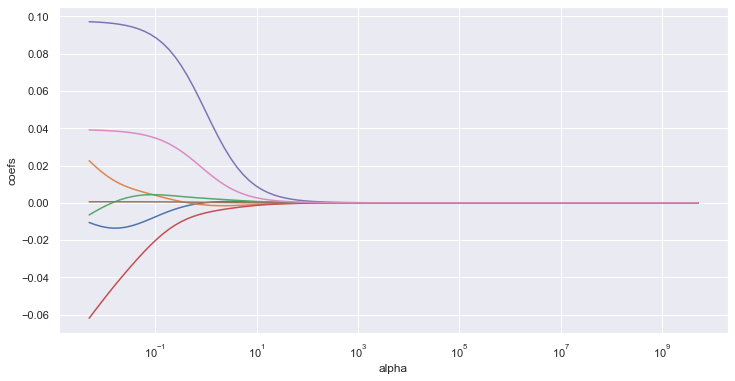

In [20]:
plt.figure(figsize=(12, 6))
ax = plt.gca()

ax.plot(alphas, coefs)

ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('coefs')

In [21]:
ridgecv = RidgeCV(alphas = alphas, 
                  scoring = 'neg_mean_squared_error', 
                  normalize = True, cv = 5)

ridgecv.fit(X_train, y_train)
ridgecv.alpha_

0.3289666123287841

In [22]:
ridge4 = Ridge(alpha = ridgecv.alpha_, normalize = True)
ridge4.fit(X_train, y_train)
ypred = ridge4.predict(X_test)
print(sqrt(mean_squared_error(y_test,ypred)))
print(r2_score(y_test,ypred))

9.88611535276303
0.0005699483396051086


In [15]:
train_df.head(5)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Distance,is_weekday
0,7.3,2010-05-03 20:30:00+00:00,-73.976540,40.755760,-73.959457,40.763329,1,1.669421,1
1,8.5,2014-03-26 01:43:00+00:00,-73.973747,40.753689,-73.950821,40.782818,1,3.769673,1
2,8.1,2011-02-02 10:48:00+00:00,-73.980515,40.730530,-74.003616,40.722664,1,2.138240,1
3,6.5,2010-04-11 12:21:00+00:00,-73.987343,40.750443,-73.967255,40.761093,2,2.067965,0
4,9.7,2011-05-01 03:17:00+00:00,-73.977600,40.784275,-73.943748,40.793705,4,3.043036,0


In [16]:
train_df['Month'] = pd.DatetimeIndex(train_df['pickup_datetime']).month
train_df['Year']  = pd.DatetimeIndex(train_df['pickup_datetime']).year
train_df['Time']  = pd.DatetimeIndex(train_df['pickup_datetime']).time
train_df['hour']  = pd.DatetimeIndex(train_df['pickup_datetime']).hour

In [17]:
train_df.head(5)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Distance,is_weekday,Month,Year,Time,hour
0,7.3,2010-05-03 20:30:00+00:00,-73.976540,40.755760,-73.959457,40.763329,1,1.669421,1,5,2010,20:30:00,20
1,8.5,2014-03-26 01:43:00+00:00,-73.973747,40.753689,-73.950821,40.782818,1,3.769673,1,3,2014,01:43:00,1
2,8.1,2011-02-02 10:48:00+00:00,-73.980515,40.730530,-74.003616,40.722664,1,2.138240,1,2,2011,10:48:00,10
3,6.5,2010-04-11 12:21:00+00:00,-73.987343,40.750443,-73.967255,40.761093,2,2.067965,0,4,2010,12:21:00,12
4,9.7,2011-05-01 03:17:00+00:00,-73.977600,40.784275,-73.943748,40.793705,4,3.043036,0,5,2011,03:17:00,3


In [18]:
train_df.dtypes

fare_amount                      float32
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float32
pickup_latitude                  float32
dropoff_longitude                float32
dropoff_latitude                 float32
passenger_count                    uint8
Distance                         float32
is_weekday                      category
Month                              int64
Year                               int64
Time                              object
hour                               int64
dtype: object

In [19]:
train_df.Month = train_df.Month.astype('uint8')

In [20]:
train_df.dtypes

fare_amount                      float32
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float32
pickup_latitude                  float32
dropoff_longitude                float32
dropoff_latitude                 float32
passenger_count                    uint8
Distance                         float32
is_weekday                      category
Month                              uint8
Year                               int64
Time                              object
hour                               int64
dtype: object

In [21]:
train_df.Time = train_df.Time.astype('str')

In [22]:
train_df.Time = pd.to_timedelta(train_df.Time)

In [23]:
train_df.dtypes

fare_amount                      float32
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float32
pickup_latitude                  float32
dropoff_longitude                float32
dropoff_latitude                 float32
passenger_count                    uint8
Distance                         float32
is_weekday                      category
Month                              uint8
Year                               int64
Time                     timedelta64[ns]
hour                               int64
dtype: object

In [24]:
train_df.Time

0       20:30:00
1       01:43:00
2       10:48:00
3       12:21:00
4       03:17:00
          ...   
99995   04:49:00
99996   13:45:00
99997   18:18:00
99998   09:55:00
99999   11:45:00
Name: Time, Length: 99993, dtype: timedelta64[ns]

In [25]:
train_df['is_night_time'] = 0
train_df.loc[(train_df.Time >= pd.to_timedelta('22:00:00')) | (train_df.Time <= pd.to_timedelta('06:00:00')),'is_night_time'] = 1

In [26]:
train_df.head(5)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Distance,is_weekday,Month,Year,Time,hour,is_night_time
0,7.3,2010-05-03 20:30:00+00:00,-73.976540,40.755760,-73.959457,40.763329,1,1.669421,1,5,2010,20:30:00,20,0
1,8.5,2014-03-26 01:43:00+00:00,-73.973747,40.753689,-73.950821,40.782818,1,3.769673,1,3,2014,01:43:00,1,1
2,8.1,2011-02-02 10:48:00+00:00,-73.980515,40.730530,-74.003616,40.722664,1,2.138240,1,2,2011,10:48:00,10,0
3,6.5,2010-04-11 12:21:00+00:00,-73.987343,40.750443,-73.967255,40.761093,2,2.067965,0,4,2010,12:21:00,12,0
4,9.7,2011-05-01 03:17:00+00:00,-73.977600,40.784275,-73.943748,40.793705,4,3.043036,0,5,2011,03:17:00,3,1


In [27]:
#drop columns which are not required
train_df.drop(['pickup_datetime','Time'],axis=1,inplace=True)

In [28]:
display(train_df.head(5))

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Distance,is_weekday,Month,Year,hour,is_night_time
0,7.3,-73.976540,40.755760,-73.959457,40.763329,1,1.669421,1,5,2010,20,0
1,8.5,-73.973747,40.753689,-73.950821,40.782818,1,3.769673,1,3,2014,1,1
2,8.1,-73.980515,40.730530,-74.003616,40.722664,1,2.138240,1,2,2011,10,0
3,6.5,-73.987343,40.750443,-73.967255,40.761093,2,2.067965,0,4,2010,12,0
4,9.7,-73.977600,40.784275,-73.943748,40.793705,4,3.043036,0,5,2011,3,1


In [29]:
X = train_df.drop(["fare_amount"],axis=1)
y = train_df.fare_amount

In [30]:
X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size = 0.25,random_state=42)

In [39]:
lm.fit(X_train,y_train)
print(lm.coef_)
print(lm.intercept_)
predict = lm.predict(X_test)
print(sqrt(mean_squared_error(y_test,predict)))
print(lm.score(X_test,y_test))

[ 6.24799135e-03  5.11809033e-02 -1.48856518e-02 -7.35858316e-02
  8.46754608e-02  5.33236186e-04  1.07398909e-01  9.69292741e-02
  6.33944928e-01 -2.86973376e-02  3.35410711e-01]
-1264.186059152584
9.79849739477781
0.018640681719775287


In [40]:
ridgecv = RidgeCV(alphas = alphas, 
                  scoring = 'r2', 
                  normalize = True, cv = 5)

ridgecv.fit(X_train, y_train)
ridgecv.alpha_

0.0466301673441609

In [41]:
ridge4 = Ridge(alpha = ridgecv.alpha_, solver='auto', normalize = True)
ridge4.fit(X_train, y_train)
ypred = ridge4.predict(X_test)
print(sqrt(mean_squared_error(y_test,ypred)))
print(r2_score(y_test,ypred))

9.799558668608936
0.018428088436677315


In [42]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
Elasticcv = ElasticNetCV(alphas = alphas, cv = 10, max_iter = 100000, normalize = True)
Elasticcv.fit(X_train, y_train)

Elastic = ElasticNet(alpha=Elasticcv.alpha_, normalize=True, max_iter=100000)
Elastic.fit(X_train, y_train)
print(sqrt(mean_squared_error(y_test, Elastic.predict(X_test))))
print(Elasticcv.alpha_)
print(r2_score(y_test,Elastic.predict(X_test)))

9.890849834933753
0.005
5.4559848042590176e-05


In [43]:
# Fitting Random Forest Regression to the dataset 
# import the regressor 
from sklearn.ensemble import RandomForestRegressor 
  
 # create regressor object 
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0) 
  
# fit the regressor with x and y data 
regressor.fit(X_train, y_train)

ypred = regressor.predict(X_test)
print("Train Accuracy: "+str(r2_score(y_train,regressor.predict(X_train))))
print("Test Accuracy: "+str(r2_score(y_test,ypred)))
print("Test RMSE: "+str(sqrt(mean_squared_error(y_test, ypred))))

Train Accuracy: 0.9614357403530787
Test Accuracy: 0.7954811168643697
Test RMSE: 4.473136616561182


In [44]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model

rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [57]:
# create regressor object 
regressor = RandomForestRegressor(n_estimators = 400, min_samples_split = 10, min_samples_leaf = 1,
                                  max_features="sqrt", max_depth=60, bootstrap=False, random_state = 0) 
  
# fit the regressor with x and y data 
regressor.fit(X_train, y_train)

ypred = regressor.predict(X_test)
print("Train Accuracy: "+str(r2_score(y_train,regressor.predict(X_train))))
print("Test Accuracy: "+str(r2_score(y_test,ypred)))
print(sqrt(mean_squared_error(y_test, ypred)))

Train Accuracy: 0.9371317770700657
Test Accuracy: 0.800609998538721
4.4166923038965145


In [58]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(regressor, X, y, cv=5)
print(scores)
print(scores.mean())
print(scores.std())

[0.72449066 0.80100575 0.78963419 0.80932929 0.79445684]
0.7837833456266008
0.030374283165620842


# PCA

In [47]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [48]:
X_train_scaled,X_test_scaled

(array([[0.0457777 , 0.77528163, 0.01588712, ..., 1.        , 0.60869565,
         0.        ],
        [0.04599953, 0.77552036, 0.016059  , ..., 0.5       , 1.        ,
         1.        ],
        [0.04565318, 0.77513026, 0.01574035, ..., 0.83333333, 0.47826087,
         0.        ],
        ...,
        [0.04597233, 0.7753556 , 0.01628357, ..., 0.33333333, 0.86956522,
         0.        ],
        [0.04586791, 0.77531911, 0.01601617, ..., 0.16666667, 0.43478261,
         0.        ],
        [0.04598463, 0.7750527 , 0.01601179, ..., 1.        , 0.43478261,
         0.        ]]),
 array([[0.04601139, 0.77552167, 0.0160452 , ..., 0.16666667, 0.60869565,
         0.        ],
        [0.04595471, 0.77545368, 0.01578873, ..., 0.33333333, 0.91304348,
         0.        ],
        [0.04604556, 0.77550958, 0.01592785, ..., 0.16666667, 0.56521739,
         0.        ],
        ...,
        [0.04939117, 0.77502801, 0.01970655, ..., 0.        , 0.69565217,
         0.        ],
        [0.0

In [49]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

In [50]:
print(X_train_scaled.shape,X_test_scaled.shape)
print(X_train_pca.shape,X_test_pca.shape)

(74996, 11) (24999, 11)
(74996, 6) (24999, 6)


In [51]:
# create regressor object 
regressor = RandomForestRegressor(n_estimators = 400, min_samples_split = 10, min_samples_leaf = 1,
                                  max_features="sqrt", max_depth=60, bootstrap=False, random_state = 0) 
  
# fit the regressor with x and y data 
regressor.fit(X_train_pca, y_train)

ypred = regressor.predict(X_test_pca)
print("Train Accuracy: "+str(r2_score(y_train,regressor.predict(X_train_pca))))
print("Test Accuracy: "+str(r2_score(y_test,ypred)))
print(sqrt(mean_squared_error(y_test, ypred)))

Train Accuracy: 0.8452426452366977
Test Accuracy: 0.19864131411938846
8.854395780340951


In [52]:
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor(  n_estimators= 500,
                                  max_depth= 4,
                                  min_samples_split= 5,
                                  learning_rate= 0.01,
                                  loss= 'ls')
reg.fit(X_train, y_train)
ypred = reg.predict(X_test)
mse = mean_squared_error(y_test, ypred)
print("Test Accuracy: "+str(r2_score(y_test,ypred)))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

Test Accuracy: 0.7965725321666739
The mean squared error (MSE) on test set: 19.9022


In [53]:
scores = cross_val_score(reg, X, y, cv=5)
print(scores)
print(scores.mean())

[0.71313967 0.78869132 0.7747355  0.79010235 0.77601391]
0.768536550154663


In [56]:
print(scores.std())

0.02840581138695691


In [31]:
X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size = 0.25,random_state=42)

In [32]:
X_train.is_weekday = X_train.is_weekday.astype('int32')
X_test.is_weekday = X_test.is_weekday.astype('int32')
X.is_weekday = X.is_weekday.astype('int32')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [33]:
import xgboost
model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=400,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) 
model.fit(X_train, y_train)
ypred = model.predict(X_test)
mse = mean_squared_error(y_test, ypred)
print("Train Accuracy: "+str(r2_score(y_train,model.predict(X_train))))
print("Test Accuracy: "+str(r2_score(y_test,ypred)))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

Train Accuracy: 0.8367331753311893
Test Accuracy: 0.7988486797236474
The mean squared error (MSE) on test set: 20.0389


In [36]:
scores = cross_val_score(model, X, y, cv=5)
print(scores)
print(scores.mean())
print(scores.std())

[0.80695298 0.80982438 0.79964793 0.79721707 0.80314685]
0.8033578443861555
0.004609950151956818


# Conclusion

As we see, XGBoost gives us the best accuracy. We can furthur do some hyperparameter tuning and feature engineering to improve the accuracy.